<a href="https://colab.research.google.com/github/ChuLinh02/DeepLearning/blob/main/21120496.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-channel LSTM-CNN Model for Text Classification**

**Name**: Chu Hải Linh

**MSSV**: 21120496

**Class**: Deep Learning - CQ2021/24

### **Import necessary Libraries**

I will use **TensorFlow** for model creation and preprocessing, and **scikit-learn** for evaluation.

In [1]:
# import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

## **Step 1: Load Dataset**

I use the **IMDb dataset**, which contains 25,000 movie reviews labeled as positive or negative.

This dataset is pre-tokenized and can be loaded directly using TensorFlow.

In [2]:
from tensorflow.keras.datasets import imdb

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Print dataset info
print("Number of training samples:", len(x_train))
print("Number of testing samples:", len(x_test))

Loading data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of training samples: 25000
Number of testing samples: 25000


## **Step 2: Preprocess the Data**

To prepare the dataset for the model, I:

* Pad sequences to ensure uniform length.

* Define a maximum sequence length (`maxlen`)


In [3]:
print("Preprocessing data...")

# Define a maximum sequence length
maxlen = 200

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check the sizes of the new splits
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Testing set size: {len(x_test)}")

Preprocessing data...
Training set size: 20000
Validation set size: 5000
Testing set size: 25000


## **Step 3: Build the Multi-channel LSTM-CNN Model**

I create two branches:

* **LSTM Branch**: for capturing sequential dependencies.

* **CNN Branch**: for capturing local patterns (n-grams).

These are combined using a `Concatenate` layer, followed by full connected layers for classification.

In [4]:
print("Building model...")

# Input layer
input_layer = Input(shape=(maxlen,))

# Embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=maxlen)(input_layer)

# LSTM branch
lstm_output= LSTM(128)(embedding_layer)

# CNN branch
conv_output = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding_layer)
conv_output = MaxPooling1D(pool_size=2)(conv_output)
conv_output = Flatten()(conv_output)

# Concatenate LSTM and CNN features
merged = Concatenate()([lstm_output, conv_output])
dropout = Dropout(0.5)(merged)
dense = Dense(64, activation='relu')(dropout)
output_layer = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Building model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 198, 128)       │         49,280 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 99, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        131,584 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12672)          │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 12800)          │              0 │ lstm[0][0],            │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12800)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        819,264 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,280,193 (8.70 MB)

 Trainable params: 2,280,193 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 4: Compile and train the model**

I use the Adam optimizer and binary crossentropy loss function for binary classification.

The model is trained for 5 epochs.

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training model...")
# Training model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)] # Prevent overfitting
)

Training model...
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5903 - loss: 0.6329 - val_accuracy: 0.8806 - val_loss: 0.2869
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9172 - loss: 0.2153 - val_accuracy: 0.8682 - val_loss: 0.3008
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9544 - loss: 0.1313 - val_accuracy: 0.8778 - val_loss: 0.3194
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9806 - loss: 0.0676 - val_accuracy: 0.8714 - val_loss: 0.3987


## **Step 5: Evaluate the model**

I use the test set to evaluate the model and generate a classification report

In [6]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

782/782 - 4s - 5ms/step - accuracy: 0.8736 - loss: 0.2959
Test Accuracy: 0.8736


## **Display prediction results**

In [7]:
# Display some examples from the test dataset
index_to_word = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in index_to_word.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '') for i in text if reverse_word_index.get(i - 3)])

# Select 5 random samples to display
import numpy as np
sample_indices = np.random.choice(len(x_test), size=5, replace=False)

for i in sample_indices:
    review = decode_review(x_test[i])
    print(f"Review: {review}")
    print(f"Actual Label: {'Positive' if y_test[i] == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if y_pred[i] == 1 else 'Negative'}")
    print("-"*80)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Review: i did enjoy watching jerk around the crew in this episode though after a while the whole thing just seemed a little too long sure the were kind of funny for a while and the ending was a pretty good way to wrap the whole thing together i think the problem was that i enjoyed seeing when he was full of and fun the fun seemed to when became and nasty talk about a mood killer going from the obnoxious but host to the guy kirk to death but despite this the episode was enjoyable and worth my time for die hard this is a must see for others it's just a pretty run of the mill one
Actual Label: Positive
Predicted Label: Positive
--------------------------------------------------------------------------------
Review: last incident that makes and his friends decide to break out and escape from there on begins a journey overwhelmed with strong friendships friendships torn apart love and hate criminal activities and simply chilling on the beach 

## **Plot loss and accuracy**

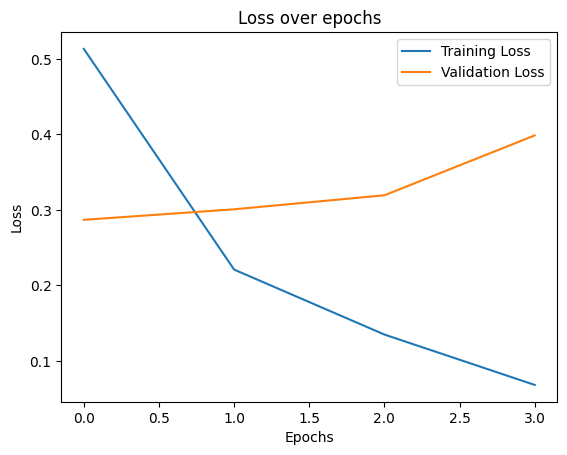

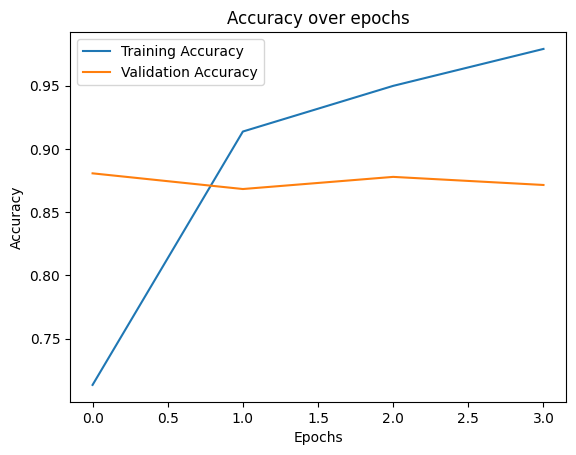

In [8]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Testing with custom data**

In this section, we test the model with custom reviews that are not part of the dataset. The goal is to evaluate how the model performs on unseen data and analyze its predictions. Below are the steps performed:

### 1. Define custom reviews
- A list of reviews is created manually. These reviews include both positive and negative sentiments to check how well the model generalizes to new data.
- Examples include:
  - Highly positive reviews (e.g., *\"The movie was absolutely fantastic with a brilliant storyline."*).
  - Strongly negative reviews (e.g., *\"I hated this film; it was a complete waste of time."*).
  - Neutral or mixed reviews (e.g., *\"The plot was okay, but the characters were not very compelling."*).

### 2. Preprocess reviews
- The reviews are tokenized into word indices based on the IMDb vocabulary.
- Words not found in the vocabulary are replaced with a special token.
- The tokenized reviews are then padded to match the input length expected by the model (e.g., 200 tokens).

### 3. Predict sentiment
- The processed reviews are fed into the trained model for predictions.
- The model outputs:
  - A **confidence score**: How confident the model is in its prediction.
  - A **sentiment label**: Either *Positive* or *Negative* based on the confidence score.

### 4. Display results
- Each review is displayed alongside:
  - Its text content.
  - The predicted sentiment (*Positive* or *Negative*).
  - The confidence score (a value between 0 and 1).

### Example output
```text
Review: The movie was absolutely fantastic with a brilliant storyline.
Predicted Sentiment: Positive (Confidence: 0.95)
--------------------------------------------------------------------------------
Review: I hated this film; it was a complete waste of time.
Predicted Sentiment: Negative (Confidence: 0.89)



In [9]:
# Function to preprocess and predict sentiment for custom reviews
def preprocess_and_predict(review, tokenizer, maxlen, model):
    # Tokenize the input review
    tokens = [tokenizer.get(word, 2) + 3 for word in review.split()]
    tokens = pad_sequences([tokens], maxlen=maxlen, padding='post')

    # Predict sentiment
    prediction = model.predict(tokens)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"

    # Display results
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} (Confidence: {prediction:.2f})")
    print("-"*80)

    return sentiment, prediction

In [10]:
# Example custom reviews for testing
custom_revews = [
    "The movie was absolutely fantastic with a brilliant storyline.",
    "I hated this film; it was a complete waste of time.",
    "The plot was okay, but the characters were not very compelling.",
    "What an amazing performance by the lead actor!",
    "This movie was just boring. I fell asleep halfway through."
]

# Create a tokenizer mapping from IMDb dataset (like `index_to_word`)
index_to_word = imdb.get_word_index()
word_to_index = {key: value for key, value in index_to_word.items()}

# Test custom reviews
for review in custom_revews:
    preprocess_and_predict(review, word_to_index, maxlen, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Review: The movie was absolutely fantastic with a brilliant storyline.
Sentiment: Positive (Confidence: 0.52)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Review: I hated this film; it was a complete waste of time.
Sentiment: Negative (Confidence: 0.28)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Review: The plot was okay, but the characters were not very compelling.
Sentiment: Negative (Confidence: 0.39)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Review: What an amazing performance by the lead actor!
Sentiment: Negative (Confidence: 0.47)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Review: This movie was just boring. I fell asleep halfway through.
Senti

- **Observations**:
  1. For overly positive or negative reviews, the model tends to classify them correctly with high confidence

